# Combustion stationnarity study
This part is dedicated to look for the time where:
1. the mass fraction quantity is stable
2. Temperature and mass fraction quantity are stable

$\color{red}{NOTE}:$ the code mainly obtained from combustion.ipynb/ combustion_with_T.ipynb/ refer to these for more details

## Fixed Temperature (Ignition) 

In [5]:
%matplotlib widget
import matplotlib.pyplot as plt
import numpy as np 
from numba import jit
from numpy import sin, pi
from pathlib import Path

%reload_ext autoreload
%aimport Funcs
%aimport visualization
%aimport species_transport
%aimport parameters
from parameters import *
from fluid_flow import dt_fluid_flow
from visualization import plot_species_overview, plot_velocity_vector_field
from species_transport import evolve_species, set_up_T, species_names
from Funcs import metric_L0, metric_RMS

In [6]:
N= 50
dx, dy, Ns_c, Nc_lw = parameters.set_resolution(N,N)
dt = dt_fluid_flow(dx, Fo=0.3)

# load the velocity field:
data_vel = Path('data/vel_field/test0') / 'UVP_N{}.npy'.format(N,N)
u,v,_ = np.load(data_vel)

# load the species and temperature fields as computed in the pre-combustion phase:
data_sp = Path('data/species/test0') / 'N{}.npy'.format(N,N)
species_data = np.load(data_sp)
Y = species_data[:-1,:, :]
T = species_data[-1, :, :]
T = set_up_T(N,N, dy, smooth=False)


In [8]:
#same technique as fluid_flow.ipynb
Tt     = 0.05
Nt     = 10
N_loop = int(Tt/dt/Nt)
Nt0    = 1

# total simulation time
t = 0.05

# time in [s] between two measurements
dt_measure = t / 200

# number of iterations between 2 convergence measurements
Nt = int(dt_measure / dt)

# number of convergence measurements
N_loop = int(t / dt_measure)

L0     = np.zeros((len(species_names),N_loop))
L2     = np.zeros_like(L0)
Y, _ = evolve_species(Nt0, Y, T, dt, u, v, dx, dy, Ns_c, Nc_lw, chem=True, dt_chem=6.4e-7, evolve_T=False)
nspec = Y.shape[0]

for i in range(N_loop):
    Y_old = Y.copy()
    Y, _ = evolve_species(Nt, Y, T, dt, u, v, dx, dy, Ns_c, Nc_lw, chem=True, dt_chem=6.4e-7, evolve_T=False)
   
    # measurements:
    for k in range(nspec):
        L0[k,i] = metric_L0(Y_old[k], Y[k])
        L2[k,i] = metric_RMS(Y_old[k], Y[k])


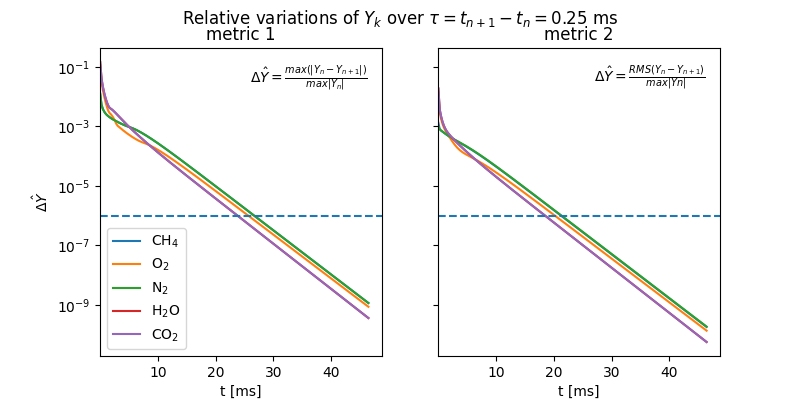

In [9]:
%autoreload 1
from visualization import plot_station_analysis
plot_station_analysis(L0, L2, Nt, Nt0, N_loop, dt, dt_measure)

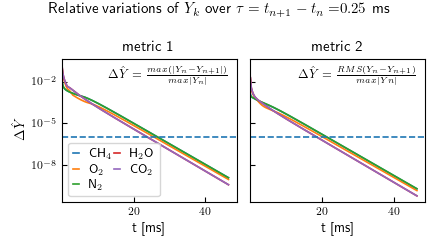

In [10]:
from plotting import set_size
plt.style.use('tex.mplstyle')
figsize = set_size(fraction=.7, aspect_r=0.4)
fig, axs = plt.subplots(1,2, figsize=figsize, sharex=True, sharey=True)
plot_station_analysis(L0, L2, Nt, Nt0, N_loop, dt, dt_measure, axs=axs)
axs[0].legend(ncol=2, handlelength=0.5, labelspacing=0.2, columnspacing=0.2, loc='lower left')
plt.tight_layout()
if True:
    fig.savefig('figures/combustion_station.svg')
    plt.style.use('default')

We see that we are easily below the $10^{-6}$ threshold if we take the stationarity time to be $t=0.03\,s$

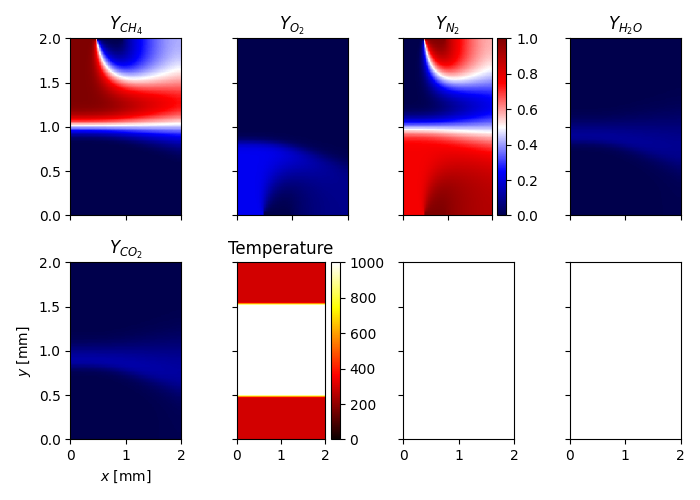

In [11]:
%autoreload 1
fig, axs =plt.subplots(2, 4, figsize=(7,5.),sharex=True, sharey=True)
plot_species_overview(Y,T, axs=axs)

Now, we will produce and save the data for all N

In [12]:
from species_transport import compute_Y_combustion, save_Y_T, load_Y_T
import time

This Part is set only to generate the CPU time as function of N unless you want to add more N to the list you do not need to execute it.
Load previous work by executing the part after this.

In [24]:
N_list = np.array([30,50,70,100,130, 160, 200,250])
#N_list = np.array([70])

Chrono = np.zeros(N_list.size)

for i, N in enumerate(N_list):
    
    print('working on N = {}'.format(N))
    
    dx, dy, Ns_c, Nc_lw = set_resolution(N,N)
    
    # load u,v
    load_p = Path('data/vel_field/test0') / 'UVP_N{}.npy'.format(N)
    u,v,_ = np.load(load_p)
    
    # load Y
    load_p_spec = Path('data/species/test0') / 'N{}.npy'.format(N)
    Y, _ = load_Y_T(load_p_spec)
    
    # set-up T
    T = set_up_T(N,N, dy, smooth=False)
    
    t0 = time.time()
    Y,T = compute_Y_combustion(N, u, v, Y, T, t=0.03)
    Chrono[i] = time.time() - t0
    
    save_p = Path('data/species_ignited/test0') / 'N{}.npy'.format(N)
    save_Y_T(Y,T,save_p)

working on N = 30
working on N = 50
working on N = 70
working on N = 100
working on N = 130


SystemError: CPUDispatcher(<function evolve_species at 0x000002069CF38F70>) returned a result with an error set

In [25]:
p = Path('data/species_ignited/test0') / 'CPU_time.npy'
if False:
    np.save(p, np.array([N_list, Chrono]))
if True:
    N_list, Chrono =np.load(p)

(8,) (8,)


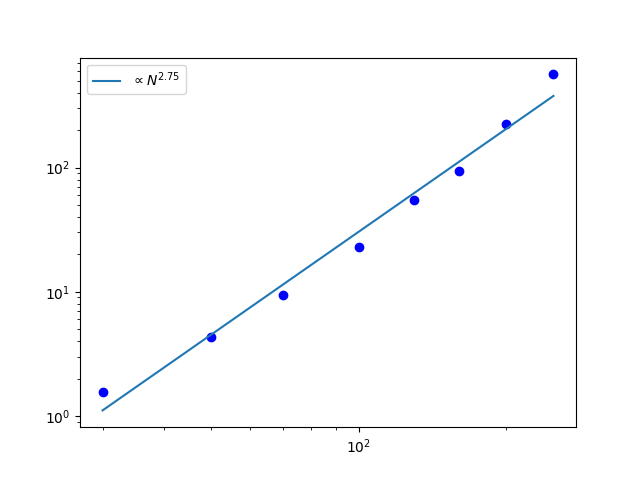

In [26]:
fig, ax = plt.subplots()
ax.plot(N_list, Chrono, 'bo')
ax.set_yscale('log')
ax.set_xscale('log')
print(N_list.shape,Chrono.shape,)
from scipy.optimize import curve_fit
def lin(x, a, b): return a*x + b 
popt, pcov = curve_fit(lin, np.log(N_list), np.log(Chrono))
a,b = popt
yopt = np.exp(b)*(N_list)**a
s = '$\propto N^{' + '{:.2f}'.format(a) + '}$'
ax.plot(N_list, yopt, label=s)
ax.legend()

## unlocked Temperature (Combustion_with_T) 

In [27]:
%matplotlib widget
import matplotlib.pyplot as plt
import numpy as np 
from numba import jit
from numpy import sin, pi
from pathlib import Path

%reload_ext autoreload
%aimport visualization
%aimport species_transport
%aimport parameters
from parameters import *
from fluid_flow import dt_fluid_flow
from visualization import plot_species_overview, plot_velocity_vector_field
from species_transport import evolve_species
from species_transport import compute_Y_combustion, save_Y_T, load_Y_T, get_dt_chem
import time

Note we have to reduce `dt` slightly by a factor 0.9 to remain stable using RK3 (instead of RK4). This does not affect the stability threshold for the parameter `dt_chem`

In [30]:
N = 70
dx, dy, Ns_c, Nc_lw = parameters.set_resolution(N,N)
dt = dt_fluid_flow(dx, Fo=0.3 * 0.5)

# load the velocity field:
data_vel = Path('data/vel_field/test0') / 'UVP_N{}.npy'.format(N)
u,v,_ = np.load(data_vel)
#plot_velocity_vector_field(u,v)

# load Y,T
data_sp = Path('data/species_ignited/test0') / 'N{}.npy'.format(N)
Y,T = load_Y_T(data_sp)
#fig, axs =plt.subplots(2, 4, figsize=(7,5.),sharex=True, sharey=True)
#plot_species_overview(Y,T, axs=axs

dt_chem = get_dt_chem(N)
print(dt_chem)

#fig, axs =plt.subplots(2, 4, figsize=(7,5.),sharex=True, sharey=True)
#plot_species_overview(Y,T, axs=axs)

2.4697e-07


In [31]:
#same technique as fluid_flow.ipynb
Tt     = 0.03
Nt     = 10
N_loop = int(Tt/dt/Nt)
Nt0    = 1

nspec = Y.shape[0]
L0     = np.zeros((nspec+1,N_loop))
L2     = np.zeros_like(L0)

dt_chem = get_dt_chem(N)
Y, T = evolve_species(Nt0, Y, T, dt, u, v, dx, dy, Ns_c, Nc_lw, chem=True, dt_chem=dt_chem, evolve_T=True);

for i in range(N_loop):
    Y_old = Y.copy()
    T_old = T.copy()
    Y, T = evolve_species(Nt, Y, T, dt, u, v, dx, dy, Ns_c, Nc_lw, chem=True, dt_chem=dt_chem, evolve_T=True);
   
    # measurements:
    for k in range(nspec):
        L0[k,i] = metric_L0(Y_old[k], Y[k])
        L2[k,i] = metric_RMS(Y_old[k], Y[k])
    L0[-1,i] = metric_L0(T_old, T)
    L2[-1,i] = metric_RMS(T_old, T)


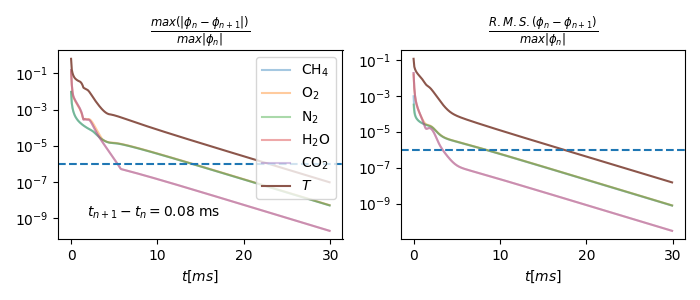

In [33]:
t = np.arange(N_loop) * dt * Nt + dt * Nt0

fig, axs = plt.subplots(1,2,figsize=(7,3),sharex=True)

for i in range(nspec+1):
    lab = '$T$' if i==nspec else species_names[i]
    alp = 1.0 if i==nspec else 0.4
    axs[0].plot(t * 1e3, L0[i], '-', label=lab, alpha=alp)
    axs[1].plot(t * 1e3, L2[i], '-', label=lab, alpha=alp)

for ax in axs:
    ax.set_yscale('log')
    ax.axhline(1e-6, ls='--')
    ax.set_xlabel('$t [ms]$')
axs[0].set_title(r'$\frac{ max ( |\phi_n - \phi_{n+1}| ) } { max |\phi_n| }$')
axs[1].set_title(r'$\frac{ R.M.S.( \phi_n - \phi_{n+1} ) }{ max |\phi_n| }$')
axs[0].legend()
s = r'$t_{n+1} - t_n = $' +'${:.2f}$ ms'.format(Nt * dt * 1e3)
axs[0].text(0.1, 0.1, s, verticalalignment='bottom', horizontalalignment='left', transform=axs[0].transAxes)

plt.tight_layout()

Again, we we can define the stationarity at $t=0.03$s, since even the Temperature variation is below 10$^{-6}$ then.

In [34]:
if False:
    fig, axs =plt.subplots(2, 4, figsize=(7,5.),sharex=True, sharey=True)
    plot_species_overview(Y,T, axs=axs)

Now iterate again through all $N$, and save the output

In [35]:
from species_transport import compute_Y_combustion_with_T 

This Part is set only to generate the CPU time as function of N unless you want to add more N to the list you do not need to execute it.
Load previous work by executing the part after this.

In [36]:
N_list = np.array([160, 200,250])
#N_list = np.array([30,50,70,100])

Chrono = np.zeros(N_list.size)

for i, N in enumerate(N_list):
    
    print('working on N = {}'.format(N))
    
    dx, dy, Ns_c, Nc_lw = set_resolution(N,N)
    
    # load u,v
    load_p = Path('data/vel_field/test0') / 'UVP_N{}.npy'.format(N)
    u,v,_ = np.load(load_p)
    
    # load Y
    load_p_spec = Path('data/species_ignited/test0') / 'N{}.npy'.format(N)
    Y, T = load_Y_T(load_p_spec)

    t0 = time.time()
    Y,T = compute_Y_combustion_with_T(N, u, v, Y, T, t=0.03)
    Chrono[i] = time.time() - t0
    
    save_p = Path('data/species_ignited_T/test0') / 'N{}.npy'.format(N)
    save_Y_T(Y,T,save_p)

working on N = 160


SystemError: CPUDispatcher(<function evolve_species at 0x000002069CF38F70>) returned a result with an error set

In [37]:
p = Path('data/species_ignited_T/test0') / 'CPU_time.npy'
if False:
    np.save(p, np.array([N_list, Chrono]))
if True:
    N_list, Chrono =np.load(p)

0.01761430046318748 1.9129485795560024


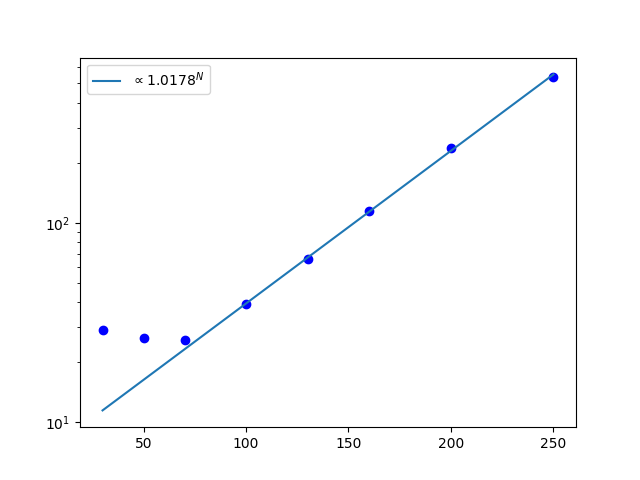

In [96]:
fig, ax = plt.subplots()
ax.plot(N_list, Chrono, 'bo')
ax.set_yscale('log')
ax.set_xscale('linear')

from scipy.optimize import curve_fit
def lin(x, a, b): return a*x + b 
popt, pcov = curve_fit(lin, (N_list[N_list>=100]), np.log(Chrono[N_list>=100]))
a,b = popt
yopt = np.exp(b+(N_list)*a)
print(a,b)
# s = '$\propto N^{' + '{:.2f}'.format(a) + '}$'
s = '$\propto {:.4f} ^N$'.format(round(np.exp(a),4))
ax.plot(N_list, yopt, label=s)
ax.legend()

We don't have a scaling CPU time $\propto N^{a}$, because there different effects that mix.<br>


$\color{red}{Slimane\ adding}$ :
1. it's looking like a dependence on $\propto a^{N}$, why?
2. in lower than 100 it's not following the low in fact it's decreasing, why? 

In [97]:
Chrono.sum() / 60

17.973151858647665